# Finding causal genotype-phenotype relations with ddlite: learning

## Introduction
In this example **ddlite** app, we'll build a system to indentify causal relationships between genotypes and phenotypes from raw journal articles. For the extraction stage, see **GenePhenRelationExample_Extraction.ipynb**.

In [2]:
%load_ext autoreload
%autoreload 2

import cPickle, os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from ddlite import *

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (18,6)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading candidate extractions
First, we'll load in the pickled candidates that we created in the last notebook. We can construct a `Relations` object with the file. We'll extract features and pickle them to save time in the future.

In [3]:
pkl_feats = 'gene_phen_relation_example/gene_phen_saved_feats_v2.pkl'
pkl_rel = 'gene_phen_relation_example/gene_phen_saved_relations_v2.pkl'
try:
    with open(pkl_feats, 'rb') as f:
        R = cPickle.load(f)
except:
    R = Relations(pkl_rel)
    %time R.extract_features()
    with open(pkl_feats, 'w+') as f:
        cPickle.dump(R, f)

## `CandidateModel` objects and feature generation
We'll then create a `CandidateModel` object for our extracted gene candidates. Features are automatically generated by `Relations`.

In [4]:
CM = CandidateModel(R)
print "Extracted {} features for each of {} mentions".format(CM.num_feats(), CM.num_candidates())

Extracted 89097 features for each of 4185 mentions


In [5]:
print "Feature sparsity: {:.5f}".format(float(CM.feats.nnz) / np.product(CM.feats.shape))

Feature sparsity: 0.00090


## Building a ground truth set
We'll load some "gold standard" labels which were generated from a previous MindTagger session. 

In [6]:
with open('gene_phen_relation_example/short_simple_holdout.pkl', 'rb') as f:
    CM.set_gold_labels(cPickle.load(f))
CM.set_holdout()

## Writing labeling functions
We'll use the **data programming method** to learn a logistic regression model which will predict the probability of a candidate entity being a true causal relationship. We'll start by writing labeling functions, or LFs. These are functions that take an `Candidate` object. They must return 1 (for a positive label), 0 (for abstaining), or -1 (for a negative example).

In [7]:
def is_gene_parent(c, key):
    return key in [c.lemmas[c.dep_parents[i] - 1] for i in c.e1_idxs]
def pre_window(c, key, n=3):
    s = list(c.e1_idxs)
    b = np.min(s)
    s.extend([b - i for i in range(1, min(b,n+1))])
    return key in [c.lemmas[i] for i in s]
def span_len(c):
    return np.min(c.e2_idxs) - np.max(c.e1_idxs)
prog = re.compile(r'\{\{G\}\}(.*)causes(.*)\{\{P\}\}')

def lf_mutation(c):
    return 1 if is_gene_parent(c, 'mutation') else 0
def lf_deletion(c):
    return 1 if pre_window(c, 'deletion') else 0
def lf_loss(c):
    return 1 if pre_window(c, 'loss') else 0
def lf_short(c):
    return 1 if np.abs(span_len(c)) < 5 else 0
def lf_long(c):
    return -1 if np.abs(span_len(c)) > 25 else 0
def lf_causes(c):
    return 1 if prog.search(c.tagged_sent) else 0

lfs = [lf_mutation, lf_deletion, lf_loss, lf_short, lf_long, lf_causes]

In [8]:
CM.apply_lfs(lfs, clear=True)

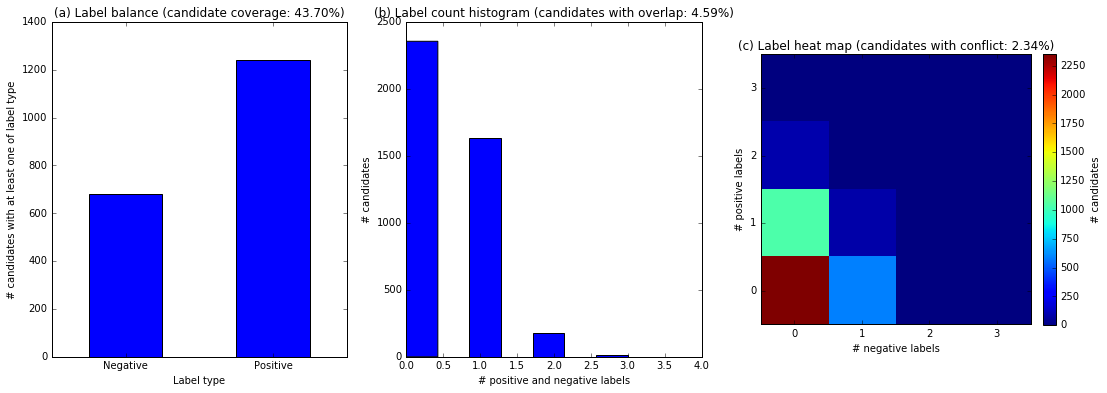

In [9]:
CM.plot_lf_stats()

In [10]:
CM.top_conflict_lfs(n=5)

TypeError: 'int' object is not iterable

In [ ]:
CM.lowest_coverage_lfs(n=5)

In [ ]:
CM.lowest_empirical_accuracy_lfs(n=10)

## Learning

In [ ]:
matplotlib.rcParams['figure.figsize'] = (12,4)
%time CM.learn_weights(tol=1e-3, sample=False, maxIter=2500, n_mu=10, mu_min_ratio=1e-9, alpha=0.5, verbose=True, plot=True, log=True)

In [ ]:
print "Number of non-zero weights: {}".format(np.sum(np.abs(CM.w) > 1e-12))